# Demo for how to perform "the ultimate fit" when tracking capillaries. In the ultimate fit, several (below we fit two profiles) line-profiles are fitted in time simultaneously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../sl2pm')

import track_vessel_A, track_vessel_B, track_vessel_C
from models import L_multi, L_multi_plasma, L_multi_wall
import misc

## Protocol A: The Ultimate Fit (both plasma and wall fluorescence)

In [2]:
kymo_wall = np.load('wall.npy')
kymo_plasma = np.load('plasma.npy')

nt, nx = kymo_wall.shape
x = np.arange(nx)

kymo_wall = kymo_wall.reshape((2, nt//2, nx)).mean(axis=1)
kymo_plasma = kymo_plasma.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [3]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [4]:
p0_A = track_vessel_A.p0_ols_ultimate(kymo_wall, kymo_plasma, ALPHA, sigma_blur=1.5)

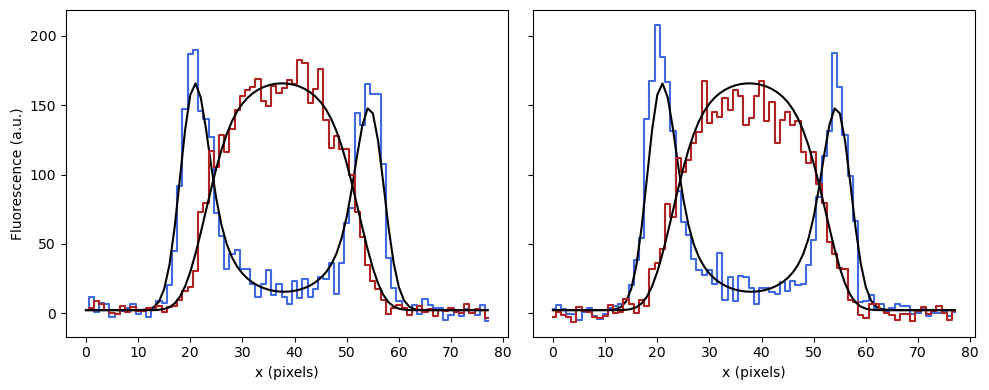

In [5]:
[[w1_A0, p1_A0], [w2_A0, p2_A0]] = L_multi(x, *p0_A)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_A0*GAIN, c='k')

ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_A0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_A0*GAIN, c='k')

ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_A0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [6]:
opt_res_A = track_vessel_A.mle_fit_ultimate(kymo_wall, kymo_plasma, N_AVER, ALPHA, SIGMA, n_r=256, n_phi=256, p0='ols', sigma_blur=1, minimize_options=dict(gtol=1e-3))
opt_res_A

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1148.2923540211677
        x: [ 2.107e+00  8.068e+00 ... -6.132e-02 -1.080e-01]
      nit: 49
      jac: [ 9.155e-05  2.441e-04 ...  2.136e-04 -3.967e-04]
 hess_inv: [[ 1.491e-03 -2.108e-02 ...  1.044e-05 -8.412e-07]
            [-2.108e-02  6.848e-01 ... -2.858e-04  4.742e-05]
            ...
            [ 1.044e-05 -2.858e-04 ...  1.336e-04 -3.251e-07]
            [-8.412e-07  4.742e-05 ... -3.251e-07  1.330e-04]]
     nfev: 1044
     njev: 58

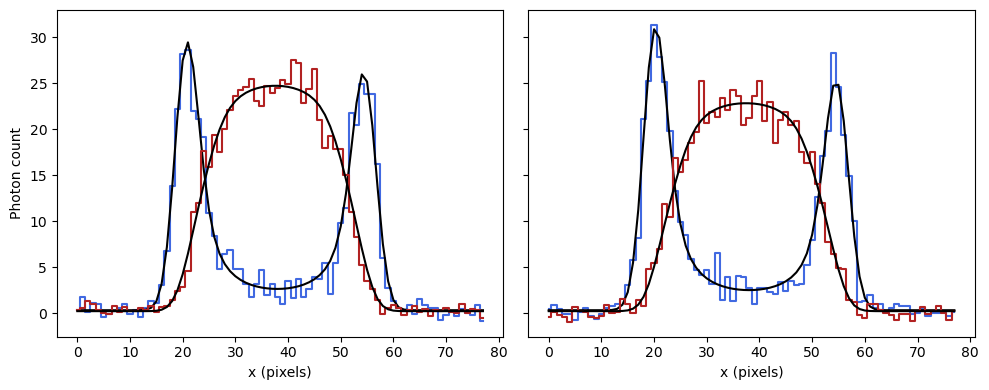

In [7]:
[[w1_A, p1_A], [w2_A, p2_A]] = L_multi(x, *opt_res_A.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0]/GAIN, where='mid', c='royalblue')
ax1.plot(x, w1_A, c='k')

ax1.step(x, kymo_plasma[0]/GAIN, where='mid', c='firebrick')
ax1.plot(x, p1_A, c='k')

# Second time point
ax2.step(x, kymo_wall[1]/GAIN, where='mid', c='royalblue')
ax2.plot(x, w2_A, c='k')

ax2.step(x, kymo_plasma[1]/GAIN, where='mid', c='firebrick')
ax2.plot(x, p2_A, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Photon count')

plt.tight_layout()

In [8]:
misc.fitted_params(opt_res_A, ['s_xy', 'l', 'dR', 's_gcx', 'b_plasma', 'b_tissue_wall', 'b_tissue_plasma', 'Iw1', 'Iw2', 'Ip1', 'Ip2', 'R_w1', 'R_w2', 'xc1', 'xc2', 'a1_1', 'a1_2'])

{'s_xy': (2.107120384465635, 0.03861545465814129),
 'l': (8.067802340891305, 0.8275130514210762),
 'dR': (6.138315160161054, 0.5908028665072856),
 's_gcx': (6.966039739209223, 1.184997663904296),
 'b_plasma': (-0.333410389283488, 0.5985847179670553),
 'b_tissue_wall': (0.33543910100606744, 0.05215161799392109),
 'b_tissue_plasma': (0.23299671535666314, 0.04735691056103153),
 'Iw1': (201.99617103320006, 9.416966719217207),
 'Iw2': (203.58070906542704, 9.129551467581418),
 'Ip1': (29.211700354055715, 0.9914267896802674),
 'Ip2': (26.735145317002385, 0.8831230765891838),
 'R_w1': (17.55982699728103, 0.06493468304855285),
 'R_w2': (17.949174070798957, 0.06440432942540274),
 'xc1': (37.61660436466941, 0.03458566958415647),
 'xc2': (37.42888523609868, 0.03465562821704428),
 'a1_1': (-0.061318138827785355, 0.01155908336804681),
 'a1_2': (-0.1079668038563857, 0.011531265154832904)}

***

## Protocol B: The Ultimate Fit (only plasma fluorescence)

In [9]:
kymo_plasma = np.load('plasma.npy')

nt, nx = kymo_plasma.shape
x = np.arange(nx)

kymo_plasma = kymo_plasma.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [10]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [11]:
p0_B = track_vessel_B.p0_ols_ultimate(kymo_plasma, ALPHA, sigma_blur=1.5)

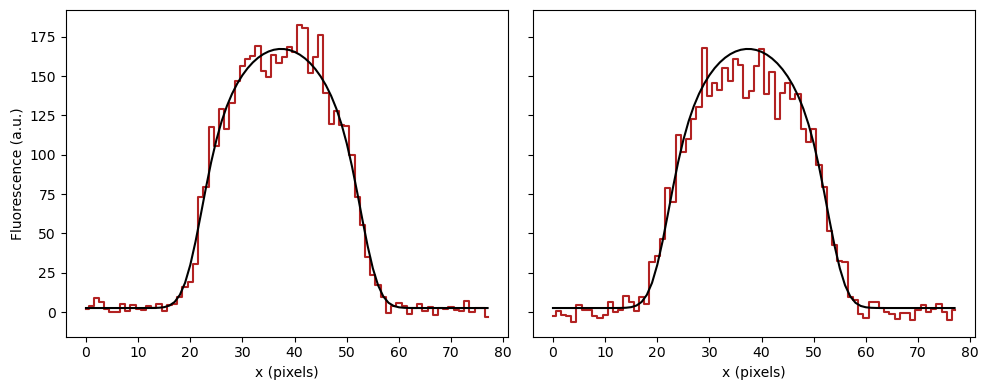

In [12]:
p1_B0, p2_B0 = L_multi_plasma(x, *p0_B)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_B0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_B0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [13]:
opt_res_B = track_vessel_B.mle_fit_ultimate(kymo_plasma, N_AVER, ALPHA, SIGMA, n_r=256, p0='ols', sigma_blur=1, minimize_options=dict(gtol=1e-4))
opt_res_B

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 525.9610675713964
        x: [-2.434e+00  2.979e+01  2.375e-01  5.990e+01  5.222e+01
             1.639e+01  1.723e+01  3.740e+01  3.732e+01]
      nit: 59
      jac: [-2.289e-05  1.526e-05 -3.052e-05  7.629e-06 -7.629e-06
            -7.629e-05  6.866e-05 -7.629e-06 -2.289e-05]
 hess_inv: [[ 1.248e-02 -1.176e-02 ...  2.005e-04  1.812e-04]
            [-1.176e-02  1.844e-02 ... -2.639e-03 -3.764e-04]
            ...
            [ 2.005e-04 -2.639e-03 ...  6.078e-03  1.066e-04]
            [ 1.812e-04 -3.764e-04 ...  1.066e-04  6.219e-03]]
     nfev: 890
     njev: 89

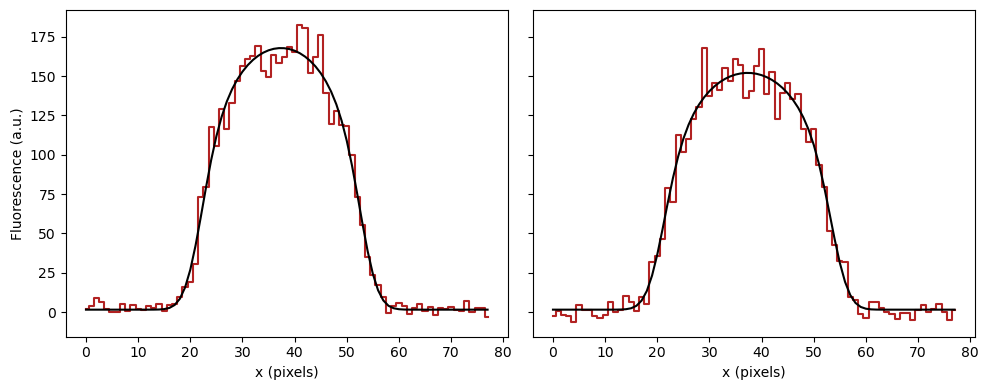

In [14]:
p1_B, p2_B = L_multi_plasma(x, *opt_res_B.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_B*GAIN, c='k')

# Second time point
ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_B*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

In [15]:
misc.fitted_params(opt_res_B, ['s_xy', 'l', 'b', 'I1', 'I2', 'R1', 'R2', 'xc1', 'xc2'])

{'s_xy': (-2.433884485763348, 0.11170146430561685),
 'l': (29.788314776076863, 0.13580247288581287),
 'b': (0.23748216653748377, 0.04805326071180383),
 'I1': (59.89907570856367, 0.9118367427304064),
 'I2': (52.22091382352405, 0.8273590556404596),
 'R1': (16.393643732038292, 0.09210969060488686),
 'R2': (17.232173186415086, 0.10048868326525146),
 'xc1': (37.39772620814984, 0.07796010107572679),
 'xc2': (37.31666025846253, 0.07886073707778792)}

***

## Protocol C: The Ultimate Fit (only wall fluorescence)

In [16]:
kymo_wall = np.load('wall.npy')

nt, nx = kymo_wall.shape
x = np.arange(nx)

kymo_wall = kymo_wall.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [17]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [18]:
p0_C = track_vessel_C.p0_ols_ultimate(kymo_wall, ALPHA, sigma_blur=1.5)

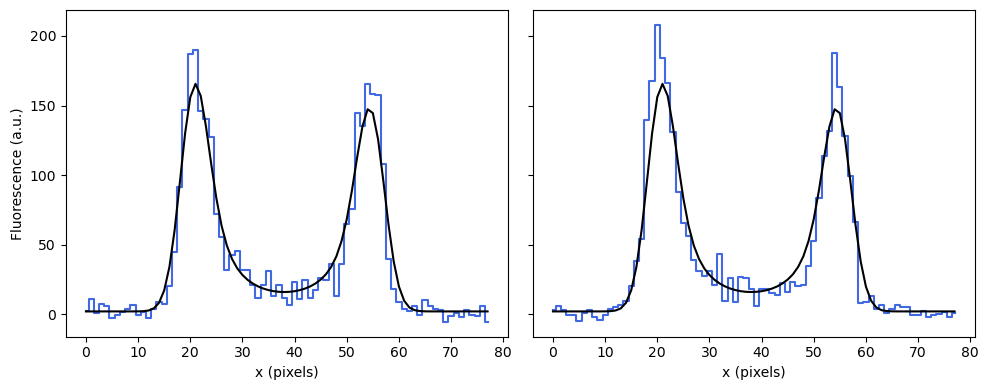

In [19]:
w1_C0, w2_C0 = L_multi_wall(x, *p0_C)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_C0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_C0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [20]:
opt_res_C = track_vessel_C.mle_fit_ultimate(kymo_wall, N_AVER, ALPHA, SIGMA, n_r=256, p0='ols', sigma_blur=1, minimize_options=dict(gtol=1e-4))
opt_res_C

/Users/drkutuzov/code/sl2pm/examples/capillaries/../../sl2pm/models.py:68: RuntimeWarning: invalid value encountered in sqrt
  integrand = gaussian(R - X_PSF, s_xy)*(1 - np.exp(-np.sqrt(R_lum**2 - R**2)/l))


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 607.6660867880826
        x: [ 2.114e+00  7.820e+00 -1.497e-01  3.334e-01  1.992e+02
             2.008e+02  1.758e+01  1.791e+01  3.767e+01  3.745e+01
            -6.249e-02 -1.085e-01]
      nit: 35
      jac: [-6.104e-05 -4.578e-05 -1.526e-05 -1.526e-05  0.000e+00
            -7.629e-06 -4.578e-05 -3.052e-05 -1.526e-05 -1.526e-05
            -1.526e-05 -3.052e-05]
 hess_inv: [[ 1.239e-03 -1.380e-02 ...  5.515e-06  4.699e-06]
            [-1.380e-02  4.310e-01 ... -8.054e-05 -1.783e-05]
            ...
            [ 5.515e-06 -8.054e-05 ...  1.491e-04  8.640e-07]
            [ 4.699e-06 -1.783e-05 ...  8.640e-07  1.486e-04]]
     nfev: 637
     njev: 49

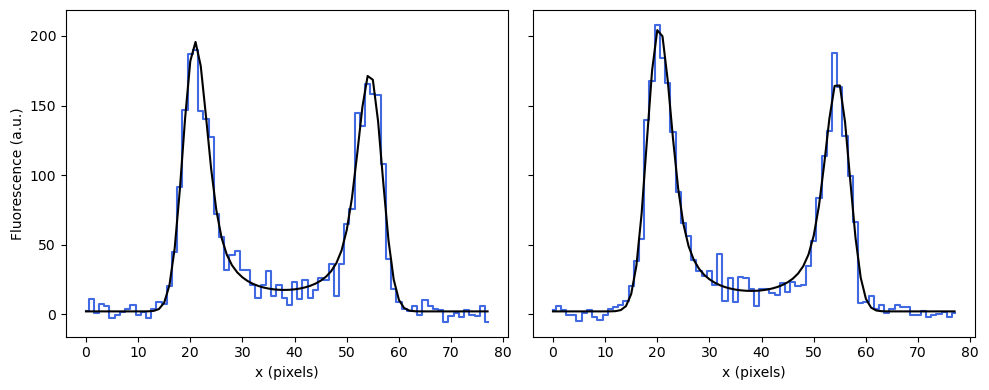

In [21]:
w1_C, w2_C = L_multi_wall(x, *opt_res_C.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_C*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_C*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

In [22]:
misc.fitted_params(opt_res_C, ['s_xy', 'l', 'b_plasma', 'b_tissue', 'Iw1', 'Iw2', 'R_w1', 'R_w2', 'xc1', 'xc2', 'a1_1', 'a1_2'])

{'s_xy': (2.114416423345813, 0.035205951726616724),
 'l': (7.819953038804413, 0.6564869731668772),
 'b_plasma': (-0.14973267917171798, 0.4836270271558356),
 'b_tissue': (0.3333878366131391, 0.052936563753398266),
 'Iw1': (199.23616722661427, 7.775573486083976),
 'Iw2': (200.7706287233943, 7.022250990142651),
 'R_w1': (17.582468548969693, 0.055361883245853255),
 'R_w2': (17.90877108669818, 0.05554493605184001),
 'xc1': (37.66982685927211, 0.038991988361797805),
 'xc2': (37.44938197524926, 0.03828995019741802),
 'a1_1': (-0.06249124342064715, 0.012212411553719243),
 'a1_2': (-0.10851098050291853, 0.012190074825235687)}